In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [123]:
import sys
sys.path.append("..")

import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

from fno_utils import FNO2d, FNODatasetSingle

In [124]:
device = "cuda"

cfg_fn = os.path.join("..", "experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [125]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("..", "experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [126]:
scores = []
downsampling = [4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("..", "experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

.H5 file extension is assumed hereafter


In [6]:
# Fixing parameters
scale = 7
dx    = pow(2, -scale)
k_s   = 1. / sqrt(pow(2, scale))

# Wavelet decomposition
wavelet_family = "db2"
wavelet = pywt.Wavelet(wavelet_family)
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

A = 0.0105 # db2: ~0.0105
B = wavelet.rec_len - 2

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx

def get_disc_idxs(xi, ks, inv_s):
    disc_xs = inv_s * xi - ks + B
    idx_tmp = np.searchsorted(x_wav, disc_xs)
    idxs = np.clip(idx_tmp - 1, 0, len(x_wav)-1)
    return idxs

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [7]:
y = yyhat[0,...,0,0].cpu().detach().numpy()

coeffs = pywt.dwt2(y, wavelet_family)
nb_levels = len(coeffs) - 1

LL, (LH, HL, HH) = coeffs
coeffs = np.array([LL, LH, HL, HH]).reshape(-1)
coeffs = np.expand_dims(np.expand_dims(coeffs, axis=-1), axis=-1)

In [8]:
x_rec  = np.arange(0, 1, dx)
x_grid = cartesian_product(x_rec, x_rec)
x_grid_offset = np.expand_dims(np.expand_dims(x_grid - A, 1), 1)

inv_s = pow(2, scale - nb_levels)
ks    = np.array([[(k_1, k_2) for k_2 in range(LL.shape[1])] for k_1 in range(LL.shape[0])])
idxs  = get_disc_idxs(x_grid_offset, ks, inv_s)

final_shape_tuple = (x_rec.shape[0], x_rec.shape[0], -1)

fL_x, fL_y = fL[idxs[...,0]].reshape(final_shape_tuple), fL[idxs[...,1]].reshape(final_shape_tuple)
fH_x, fH_y = fH[idxs[...,0]].reshape(final_shape_tuple), fH[idxs[...,1]].reshape(final_shape_tuple)

disc_fLL = (fL_x * fL_y).reshape(final_shape_tuple)
disc_fLH = (fH_x * fL_y).reshape(final_shape_tuple)
disc_fHL = (fL_x * fH_y).reshape(final_shape_tuple)
disc_fHH = (fH_x * fH_y).reshape(final_shape_tuple)
disc_f   = (k_s * sqrt(inv_s) / sqrt(2)) * np.concatenate([disc_fLL, disc_fLH, disc_fHL, disc_fHH], axis=-1)
disc_f   = np.transpose(disc_f, axes=(2, 0, 1))

In [9]:
y_rec = np.sum(disc_f * coeffs, axis=0)

In [56]:
def basin_integral(f, center, radius):
    integral_mask = (np.linalg.norm(x_grid - center, axis=1) < radius).astype(np.int8).reshape(y_rec.shape)
    return np.sum(f * integral_mask)

In [57]:
basin_center  = np.array([0.75, 0.6])
basin_radius  = 0.2
integral      = basin_integral(disc_f[0], basin_center, basin_radius)

In [49]:
# ---------------------------------
# yhat = yhat.reshape(1, -1)
# y    = yybatch[0, ...,0,0]

In [33]:
diff = y - yhat
diff = diff.reshape(diff.shape[0], -1).detach().cpu().numpy()
# np.linalg.norm(diff.reshape(diff.shape[0], -1), ord=2)

In [127]:
import cvxpy as cp
from wavelet import get_disc_grid

y = yy[0, ...,1,0].detach().cpu().numpy()
x_grid = get_disc_grid(y.shape[0])
candidate_w = x_grid.copy()
r = 0.05

In [128]:
tiled_x_grid = np.tile(x_grid, (x_grid.shape[0], 1, 1))
tiled_offset = np.transpose(np.tile(candidate_w, (candidate_w.shape[0], 1, 1)), (1, 0, 2))

In [129]:
offsets = tiled_x_grid - tiled_offset

In [130]:
masks = np.linalg.norm(offsets, axis=-1) < r

In [131]:
masks = masks.reshape(masks.shape[0], y.shape[0], y.shape[1])

In [132]:
objs = np.sum(y * masks, axis=(1,2))

In [133]:
wstar = candidate_w[np.argmax(objs)]

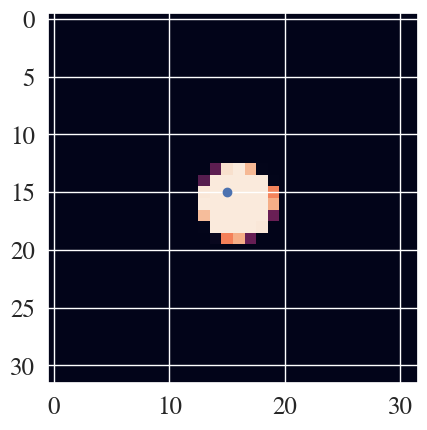

In [134]:
plt.scatter([wstar[1] * y.shape[1]], [wstar[0] * y.shape[0]])
plt.imshow(y)

In [200]:
# Linf robust version --
yhat = y.flatten()
w = np.array([0.6, 0.6])
r = 0.05

constraint_to_opt = {
    "l2": None,
    "linf": None,
    "c3": None,
}
constraint_to_quantile = {
    "l2": 25.0,
    "linf": 1.0,
    "c3": 1_000,
}

for constraint in ["l2", "linf"]:
    x_grid = get_disc_grid(y.shape[0])
    w_mask = (np.linalg.norm(x_grid - w, axis=1) < r).astype(np.int8)

    u = cp.Variable(yhat.shape)

    objective = cp.Minimize(-u @ w_mask)
    norm_ord = 2 if constraint == "l2" else "inf"
    constraints = [cp.norm(u - yhat, norm_ord) <= constraint_to_quantile[constraint]]
    prob = cp.Problem(objective, constraints)
    obj  = prob.solve()

    constraint_to_opt[constraint] = u.value.reshape(y.shape)

In [204]:
from wavelet import WaveletBasis, get_disc_grid
from calibrate import get_partials

wavelet_basis = WaveletBasis()

# amortized definition of basis partials for Sobolev norm computation
uhat_coeffs = wavelet_basis.get_decomp(y)
shaped_basis = wavelet_basis.basis_func.reshape(wavelet_basis.basis_func.shape[1], y.shape[0], y.shape[1])
partials = get_partials(shaped_basis)
partials = [
        np.transpose(np.array([partial.reshape(partial.shape[0], -1) for partial in partial_order]), (0, 2, 1)) 
        for partial_order in partials
]
x_grid = wavelet_basis.x_grid.reshape(y.shape[0], y.shape[1], -1)

In [137]:
u_coeff = cp.Variable(uhat_coeffs.shape)

integral_mask = (np.linalg.norm(wavelet_basis.x_grid - w, axis=1) < r).astype(np.int8).reshape(y.shape)
psi_w = np.sum(shaped_basis * integral_mask, axis=(1,2))
objective = cp.Minimize(-u_coeff @ psi_w)

constraints = [
    cp.sum([
        cp.max(cp.hstack([
            cp.abs(partial @ (uhat_coeffs - u_coeff)) for partial in partial_order
        ])) for partial_order in partials
    ]) <= constraint_to_quantile["c3"]
]

prob = cp.Problem(objective, constraints)
obj  = prob.solve()
constraint_to_opt["c3"] = (wavelet_basis.basis_func @ u_coeff.value).reshape(y.shape)

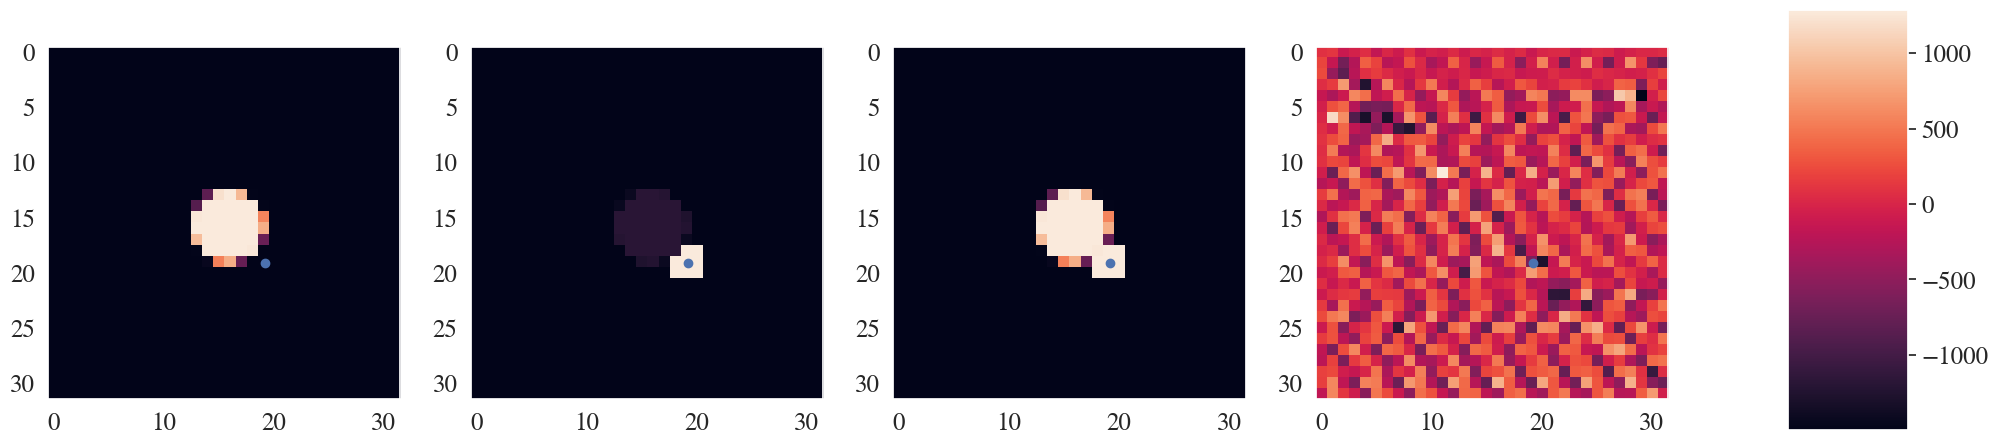

In [138]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))

axs[0].imshow(y)
axs[0].scatter([w[1] * y.shape[1]], [w[0] * y.shape[0]])
axs[0].grid(False)

for i, constraint in enumerate(constraint_to_opt):
    im = axs[i+1].imshow(constraint_to_opt[constraint])
    axs[i+1].scatter([w[1] * y.shape[1]], [w[0] * y.shape[0]])
    axs[i+1].grid(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [139]:
def grad(u):
    eps = 5e-2
    bd_mask = (np.abs(np.linalg.norm(x_grid - w, axis=-1) - r) < eps).astype(np.int8)
    w_grad_field = np.expand_dims(bd_mask, axis=-1) * (w - x_grid) * np.expand_dims(u, axis=-1)
    w_grad = np.sum(w_grad_field, axis=(0, 1))
    return w_grad

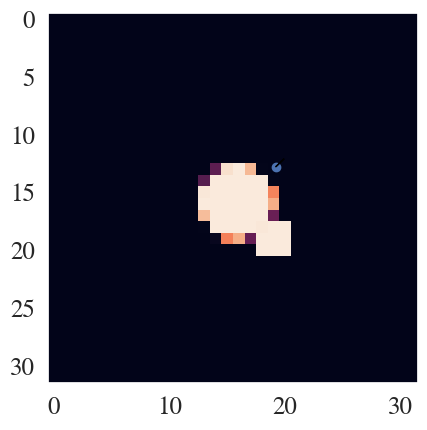

In [154]:
u  = constraint_to_opt["linf"]

w = np.array([0.4, 0.6])
pt = w * y.shape
pt_grad = grad(u)
pt_grad = pt_grad / np.linalg.norm(pt_grad)

plt.grid(False)
plt.imshow(u)
plt.scatter([pt[1]], [pt[0]])
plt.arrow(pt[1], pt[0], pt_grad[1], pt_grad[0], color='black')

In [253]:
constraint_to_ws = {
    "true": [],
    "l2":   [],
    "linf": [],
    "c3":   [],
}

In [265]:
# problem specification (constant over optimization)
eta       = 1e-2
max_iters = 100
score_func = "linf"

u_stars =[]
ws      = []
w_grads = []

w = np.array([0.4, 0.6])
for iter in range(max_iters):
    yhat = y.flatten()
    w_mask = (np.linalg.norm(wavelet_basis.x_grid - w, axis=1) < r).astype(np.int8)
    norm_ord = 2 if score_func == "l2" else "inf"

    if score_func in ["l2", "linf"]:
        u = cp.Variable(yhat.shape)
        objective = cp.Minimize(-u @ w_mask)
        constraints = [cp.norm(u - yhat, norm_ord) <= constraint_to_quantile[score_func]]
        prob = cp.Problem(objective, constraints)
        obj  = prob.solve()
        u_star = u.value.reshape(y.shape)
    elif score_func == "c3":
        u_coeff = cp.Variable(uhat_coeffs.shape)

        integral_mask = (np.linalg.norm(wavelet_basis.x_grid - w, axis=1) < r).astype(np.int8).reshape(y.shape)
        psi_w = np.sum(shaped_basis * integral_mask, axis=(1,2))
        objective = cp.Minimize(-u_coeff @ psi_w)

        constraints = [
            cp.sum([
                cp.max(cp.hstack([
                    cp.abs(partial @ (uhat_coeffs - u_coeff)) for partial in partial_order
                ])) for partial_order in partials
            ]) <= constraint_to_quantile[score_func]
        ]

        prob = cp.Problem(objective, constraints)
        obj  = prob.solve()
        u_star = (wavelet_basis.basis_func @ u_coeff.value).reshape(y.shape)
    elif score_func == "true":
        u_star = y

    # ---- Update to w^(t+1) using u^*
    eps = 5e-2
    bd_mask = (np.abs(np.linalg.norm(x_grid - w, axis=-1) - r) < eps).astype(np.int8)
    w_grad_field = np.expand_dims(bd_mask, axis=-1) * (w - x_grid) * np.expand_dims(u_star, axis=-1)
    w_grad = np.sum(w_grad_field, axis=(0, 1))
    # w_grad = w_grad / np.linalg.norm(w_grad)
    w = w - eta * w_grad
    # print(f"{iter} : w : {w} -- w_grad : {np.linalg.norm(w_grad)}")
    
    u_stars.append(u_star)
    ws.append(w)
    w_grads.append(w_grad)
constraint_to_ws[score_func] = np.array(ws)

0
1
2


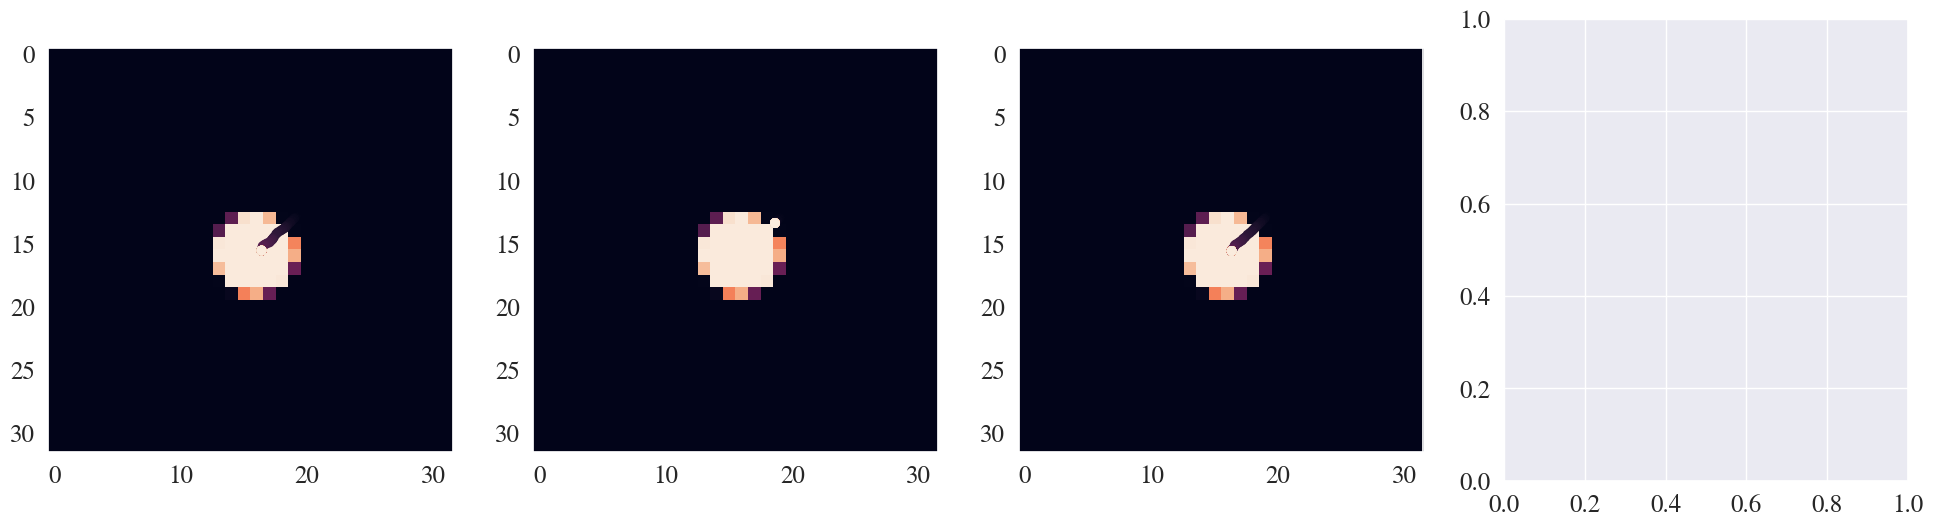

In [266]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))
for i, constraint in enumerate(constraint_to_ws):
    ws = np.array(constraint_to_ws[constraint])
    if len(ws) == 0:
        continue

    print(i)
    axs[i].imshow(y)
    axs[i].scatter(ws[:,1] * y.shape[1], ws[:,0] * y.shape[1], c=range(len(ws)))
    axs[i].grid(False)

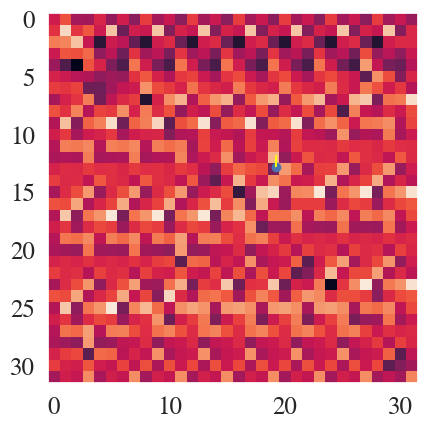

In [224]:
idx = 0

w = np.array([0.4, 0.6])
pt = w * y.shape
pt_grad = w_grads[idx]
pt_grad = pt_grad / np.linalg.norm(pt_grad)

plt.grid(False)
plt.imshow(u_stars[idx])
plt.scatter([pt[1]], [pt[0]])
plt.arrow(pt[1], pt[0], pt_grad[1], pt_grad[0], color='yellow')